In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time

Lets define a function that will help us find the smallest width and height of images in dataset for rescaling.

In [4]:
def smallest_image_sizes(main_folder):

    widths = []
    heights = []

    smallest_width, smallest_height = float('inf'), float('inf')

    for subfolder in os.listdir(main_folder):
        subdir = os.path.join(main_folder, subfolder)

        if os.path.isdir(subdir):

            for filename in os.listdir(subdir):
                file_path = os.path.join(subdir, filename)

                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Load the image using OpenCV
                    image = cv.imread(file_path)

                    # Ensure the image was loaded successfully
                    if image is not None:
                        # Get the dimensions of the image
                        height, width, _ = image.shape
                        smallest_width = min(smallest_width, width)
                        smallest_height = min(smallest_height, height)
                        widths.append(width)
                        heights.append(height)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].hist(widths, bins=20, color='blue', alpha=0.7)
    axs[0].set_title('Histogram of Image Widths')
    axs[0].set_xlabel('Width')
    axs[0].set_ylabel('Frequency')

    # Plot histogram of heights
    axs[1].hist(heights, bins=20, color='green', alpha=0.7)
    axs[1].set_title('Histogram of Image Heights')
    axs[1].set_xlabel('Height')
    axs[1].set_ylabel('Frequency')

    # Show plots
    plt.tight_layout()
    plt.show()
    
    return int(smallest_width), int(smallest_height)

Now lets make a function for loading the images and splitting them into training and validation set (test set is already separated).

In [5]:
def load_images(main_folder, val_ratio, test_ratio, smallest_width, smallest_height, shuffle = True, random_seed = 42):

    assert val_ratio < 1  and val_ratio >= 0
    assert test_ratio < 1 and test_ratio >= 0
    assert val_ratio+test_ratio < 1

    random.seed(random_seed)

    train_image_array = []
    train_labels = []
    val_image_array = []
    val_labels = []
    test_image_array = []
    test_labels = []
    labels = {}
    for label, subfolder in enumerate(os.listdir(main_folder)):
        labels[label] = subfolder
        subdir = os.path.join(main_folder, subfolder)
        subfolder_image_array = []
        subfolder_labels = []

        if os.path.isdir(subdir):

            for filename in os.listdir(subdir):
                file_path = os.path.join(subdir, filename)

                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Load the image using OpenCV
                    image = cv.imread(file_path)
                    image = cv.resize(image, (smallest_width, smallest_height), interpolation=cv.INTER_AREA)

                    # Ensure the image was loaded successfully
                    if image is not None:
                        # Convert BGR to RGB
                        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                        subfolder_image_array.append(image)
                        subfolder_labels.append(label)
            
            n_train = int((1 - val_ratio) * (1 - test_ratio) * len(subfolder_image_array))
            n_val = int(val_ratio * (1 - test_ratio) * len(subfolder_image_array))

            combined = list(zip(subfolder_image_array, subfolder_labels))
            random.shuffle(combined)
            subfolder_image_array, subfolder_labels = zip(*combined)

            for i, image in enumerate(subfolder_image_array):
                if i < n_train:
                    train_image_array.append(image)
                    train_labels.append(subfolder_labels[i])
                elif n_train < i < n_train + n_val:
                    val_image_array.append(image)
                    val_labels.append(subfolder_labels[i])
                else:
                    test_image_array.append(image)
                    test_labels.append(subfolder_labels[i])

    if test_ratio > 0 and val_ratio > 0:
        return labels, np.array(train_image_array), np.array(val_image_array), np.array(test_image_array), np.array(train_labels), np.array(val_labels), np.array(test_labels)
    elif val_ratio > 0:
        return labels, np.array(train_image_array), np.array(val_image_array), np.array(train_labels), np.array(val_labels)
    elif test_ratio > 0:
        return labels, np.array(train_image_array), np.array(test_image_array), np.array(train_labels), np.array(test_labels)
    else:
        return labels, np.array(train_image_array), np.array(train_labels)

Function for one-hot encoding the labels of images.

In [6]:
def one_hot_encode(y, class_dict):
    
    one_hot_encoded = []
    
    for num in y:
        one_hot_vector = np.zeros(len(class_dict))
        
        index = list(class_dict.values()).index(class_dict[num])
        
        one_hot_vector[index] = 1
        one_hot_encoded.append(one_hot_vector)
    
    one_hot_encoded = np.array(one_hot_encoded)
    return one_hot_encoded

Okay now lest find the smallest width and height in dataset, load and rescale the images.

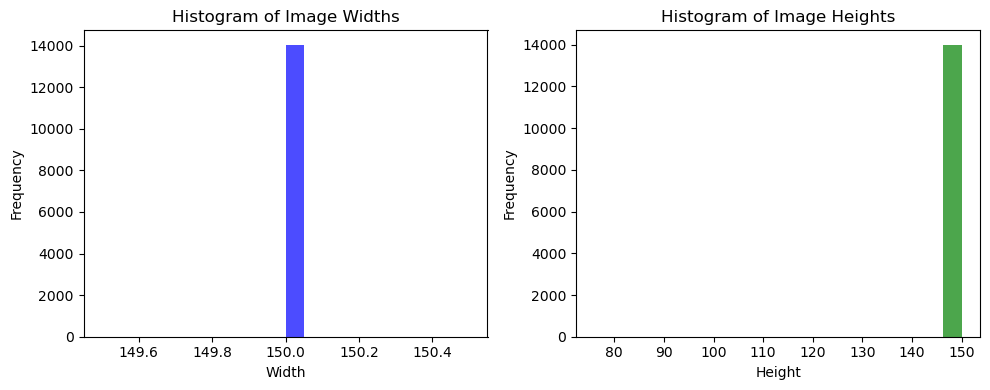

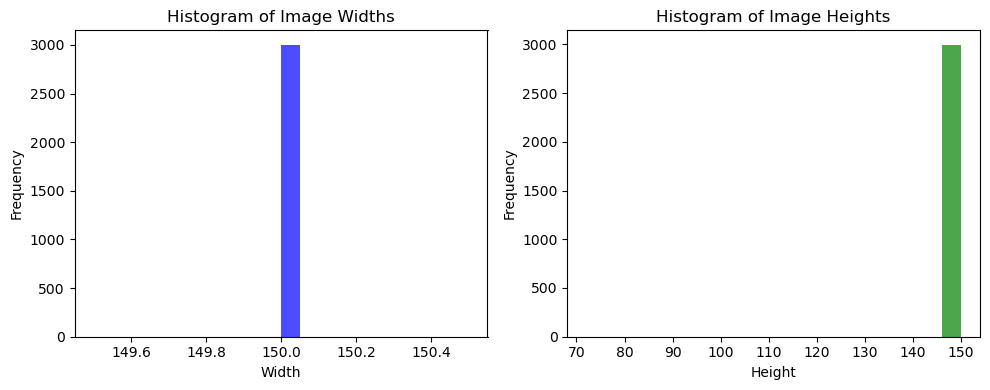

150 72


In [7]:
train_folder_path = 'Classification_data/train'
test_folder_path = 'Classification_data/test'

smallest_width1, smallest_height1 = smallest_image_sizes(train_folder_path)
smallest_width2, smallest_height2 = smallest_image_sizes(test_folder_path)

smallest_width = min(smallest_width1,smallest_width2)
smallest_height = min(smallest_height1,smallest_height2)
print(smallest_width, smallest_height)

From the histograms of widths and heights in training and test set images we can see that they are already the same size.

In [8]:
labels, X_train, y_train = load_images(train_folder_path, 0, 0, smallest_width, smallest_height)
_, X_test, y_test        = load_images(test_folder_path, 0, 0, smallest_width, smallest_height)


# Normalizing the pixels values
X_train, X_test = X_train / 255.0, X_test / 255.0

In [7]:
X_train.shape

(14034, 72, 150, 3)

Lets check if images were loaded correctly.

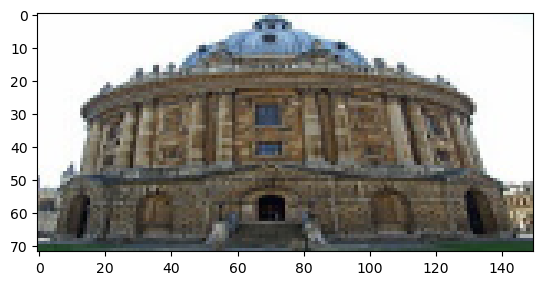

In [8]:
plt.imshow(X_train[500])

In [9]:
print(labels[y_train[500]])

buildings


Here we will create a function for extraction of Histogram of Gradients (HOG) from the images. This will allow us to train some classical machine learning model for the classification task.

In [26]:
def extract_hog_features(images, resize_dim=(64, 128), win_size=(32, 32), block_size=(16, 16), block_stride=(16, 16), cell_size=(16, 16), nbins=9):

    hog = cv.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    
    hog_features = []
    
    for image in images:

        image = cv.convertScaleAbs(image)
        gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        resized_image = cv.resize(gray_image, resize_dim)
        
        features = hog.compute(resized_image)
        hog_features.append(features.flatten())
    
    hog_features = np.array(hog_features)
    
    return hog_features


Another feature extractor. This time we are obtaining ORB descriptors (corners and edges information).

In [11]:
def extract_orb_features(images):
    orb = cv.ORB_create()
    features = []
    
    for image in images:

        image = cv.convertScaleAbs(image)
        gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

        keypoints, descriptors = orb.detectAndCompute(gray_image, None)
        
        # Flatten the descriptors and append to features list
        if descriptors is not None:
            features.append(descriptors.flatten())
        else:
            features.append(np.zeros(256))  # Placeholder for images where no keypoints are found
    
    return np.array(features)

X_train_SVM = extract_orb_features(X_train).astype('float32')
X_test_SVM = extract_orb_features(X_test).astype('float32')

print(X_train_SVM.shape)  

(14034, 256)


In [12]:
X_train_SVM.dtype

dtype('float32')

In [13]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

A code for training SVM Classifier with cross-validation for tuning hyperparameters.

In [27]:
X_train_SVM = extract_hog_features(X_train)
X_test_SVM = extract_hog_features(X_test)

print(X_train_SVM.shape)  

(14034, 90)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_SVM)
X_test_scaled = scaler.transform(X_test_SVM)

#clf = svm.LinearSVC()#
clf = svm.SVC(kernel='rbf', C=1, probability=True)
'''
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': [ 'rbf']}
#param_grid = {'C': [0.1, 1, 10, 100]}

grid_search = GridSearchCV(clf, param_grid, cv=4, verbose=3)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_

y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Parameters: {best_params}")
'''
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 57.77%


SVM performance is rather mediocre but with more detailed extraction of features and hyperparameter tuning it could perform much better. However training time for SVM scales quadratic with the number of features so it would take quite a long time.

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_SVM)
X_test_scaled = scaler.transform(X_test_SVM)

clf = KNeighborsClassifier()

# Parameter grid for KNN
param_grid = {'n_neighbors': [60,80]}

# Grid search using cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_

# Predictions on test set
y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Best Parameters: {best_params}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ....................n_neighbors=60;, score=0.411 total time=   0.7s
[CV 2/5] END ....................n_neighbors=60;, score=0.404 total time=   0.6s
[CV 3/5] END ....................n_neighbors=60;, score=0.388 total time=   0.6s
[CV 4/5] END ....................n_neighbors=60;, score=0.401 total time=   0.6s
[CV 5/5] END ....................n_neighbors=60;, score=0.405 total time=   0.6s
[CV 1/5] END ....................n_neighbors=80;, score=0.406 total time=   0.5s
[CV 2/5] END ....................n_neighbors=80;, score=0.401 total time=   0.5s
[CV 3/5] END ....................n_neighbors=80;, score=0.379 total time=   0.6s
[CV 4/5] END ....................n_neighbors=80;, score=0.398 total time=   0.6s
[CV 5/5] END ....................n_neighbors=80;, score=0.402 total time=   0.6s
Best Parameters: {'n_neighbors': 60}
Test Accuracy: 41.37%


KNN performed rather poorly on the given set of features.

## Neural network approach

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print('cuda')
else:
    print('no cuda')

cuda


Here we will construct a class for our CNN.

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes, input_shape=[3, smallest_height, smallest_width]):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=7, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate the input size for fc1 dynamically
        self.fc1_input_size = self._calculate_fc1_input_size(input_shape)
        print(self.fc1_input_size)
        
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def _calculate_fc1_input_size(self, input_shape):
        x = torch.zeros(1, *input_shape)  # Create a dummy input tensor
        x = self.conv_layers(x)
        
        # Calculate the number of features after the convolutional and pooling layers
        num_features = x.view(x.size(0), -1).size(1)
        
        return num_features
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [49]:
labels, X_train, X_val, y_train, y_val = load_images(train_folder_path, 0.2, 0, smallest_width, smallest_height)
_, X_test, y_test                     = load_images(test_folder_path, 0, 0, smallest_width, smallest_height)

X_train, X_valid, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

y_train = one_hot_encode(y_train,labels)
y_val = one_hot_encode(y_val,labels)
y_test  = one_hot_encode(y_test,labels)

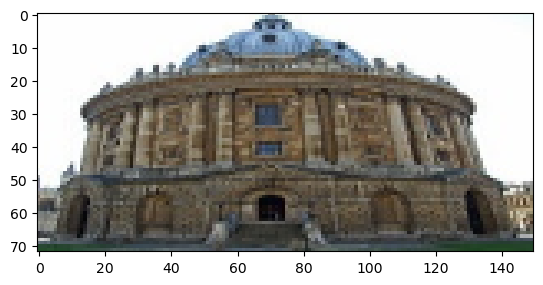

In [14]:
plt.imshow(X_train[500])

In [15]:
print(labels[np.nonzero(y_train[500])[0][0]])

buildings


Lets convert our data to torch tensors and create data loaders. We will also initialize our CNN, optimizer will be Adam and loss function - cross entropy.

In [50]:
X_train_tensor = torch.tensor(X_train.transpose((0, 3, 1, 2)), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.transpose((0, 3, 1, 2)), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.transpose((0, 3, 1, 2)), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = CNN(num_classes=len(labels)) 
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

18432


In [17]:
X_train_tensor.shape

torch.Size([11224, 3, 72, 150])

Time for training.

In [18]:
train_history = []
val_history = []

best_val_accuracy = 0.0  
best_model_params = None  

num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    
    for inputs, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels, dim=1)  
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss
    avg_train_loss = total_loss / len(train_loader.dataset)
    train_history.append(avg_train_loss)

    # Validation loop
    model.eval()
    total_correct = 0
    total_val_loss = 0.0

    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot encoded labels to class indices
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total_correct += (predicted == labels).sum().item()

            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item() * inputs.size(0)
    
    # Calculate validation accuracy
    val_accuracy = total_correct / len(val_loader.dataset)
    val_history.append(val_accuracy)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    
    # Save best model parameters
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_params = model.state_dict()

    end_time = time.time()
    epoch_time = end_time - start_time
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")

# Load best model parameters
model.load_state_dict(best_model_params)


Epoch 1/20, Loss: 1.0630, Validation Accuracy: 43.60%, Time: 183.90s
Epoch 2/20, Loss: 0.8431, Validation Accuracy: 36.13%, Time: 178.22s
Epoch 3/20, Loss: 0.7115, Validation Accuracy: 34.35%, Time: 174.08s
Epoch 4/20, Loss: 0.6362, Validation Accuracy: 51.11%, Time: 170.19s
Epoch 5/20, Loss: 0.5431, Validation Accuracy: 57.36%, Time: 165.41s
Epoch 6/20, Loss: 0.4655, Validation Accuracy: 56.97%, Time: 166.71s
Epoch 7/20, Loss: 0.3864, Validation Accuracy: 52.82%, Time: 171.78s
Epoch 8/20, Loss: 0.3065, Validation Accuracy: 62.62%, Time: 177.64s
Epoch 9/20, Loss: 0.2417, Validation Accuracy: 51.11%, Time: 177.15s
Epoch 10/20, Loss: 0.1924, Validation Accuracy: 62.19%, Time: 175.57s
Epoch 11/20, Loss: 0.1338, Validation Accuracy: 65.33%, Time: 171.04s
Epoch 12/20, Loss: 0.1169, Validation Accuracy: 54.36%, Time: 170.88s
Epoch 13/20, Loss: 0.1120, Validation Accuracy: 65.48%, Time: 171.79s
Epoch 14/20, Loss: 0.0975, Validation Accuracy: 65.80%, Time: 173.16s
Epoch 15/20, Loss: 0.0622, Va

<All keys matched successfully>

In [19]:
# Test evaluation
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
total_correct = 0

with torch.no_grad():
    for batch in test_loader:

        inputs, one_hot_labels = batch  # Assuming labels are one-hot encoded
        labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot encoded labels to class indices
        
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total_correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = total_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 74.13%


Not bad - we succesfully classify 3 out of 4 pictures.

## Finetuned CNN

We will use SqueezeNet - it is lightweight network with relatively small number of parameters and its flexible in case of input size.

In [53]:
import torchvision.models as models

# Load pretrained ResNet-18 model
squeeze = models.squeezenet1_0(weights='SqueezeNet1_0_Weights.DEFAULT')#.to(device)

In [57]:
num_classes = len(labels)  

# Modify final layer
#num_features = squeeze.fc.in_features
#squeeze.fc = nn.Linear(num_features, num_classes)

Lets take a look at its architecture.

In [58]:
squeeze.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

Freezing the layers to prevent them from updating weights  (transfer learning).

We choose cross entropy as our loss and Stochastic Gradient Descent as our optimizer.

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeeze.parameters(), lr=0.001, momentum=0.9)

Now lets train the model.

In [60]:
train_res_history = []
val_res_history = []

best_val_accuracy = 0.0  
best_model_params = None  

num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()
    
    squeeze.train()
    total_loss = 0.0
    
    for inputs, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels, dim=1)  
        optimizer.zero_grad()
        
        outputs = squeeze(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss
    avg_train_loss = total_loss / len(train_loader.dataset)
    train_res_history.append(avg_train_loss)

    # Validation loop
    squeeze.eval()
    total_correct = 0
    total_val_loss = 0.0

    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot encoded labels to class indices
            
            outputs = squeeze(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total_correct += (predicted == labels).sum().item()

            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item() * inputs.size(0)
    
    # Calculate validation accuracy
    val_accuracy = total_correct / len(val_loader.dataset)
    val_res_history.append(val_accuracy)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    
    # Save best model parameters
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_res_params = squeeze.state_dict()

    end_time = time.time()
    epoch_time = end_time - start_time
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")

# Load best model parameters
squeeze.load_state_dict(best_res_params)


Epoch 1/10, Loss: 1.0947, Validation Accuracy: 43.60%, Time: 315.63s
Epoch 2/10, Loss: 0.5542, Validation Accuracy: 47.32%, Time: 297.16s
Epoch 3/10, Loss: 0.4711, Validation Accuracy: 56.22%, Time: 299.15s
Epoch 4/10, Loss: 0.4001, Validation Accuracy: 43.64%, Time: 290.14s
Epoch 5/10, Loss: 0.3795, Validation Accuracy: 54.40%, Time: 286.98s
Epoch 6/10, Loss: 0.3476, Validation Accuracy: 51.29%, Time: 314.86s
Epoch 7/10, Loss: 0.3344, Validation Accuracy: 60.65%, Time: 314.07s
Epoch 8/10, Loss: 0.3034, Validation Accuracy: 60.15%, Time: 297.32s
Epoch 9/10, Loss: 0.2814, Validation Accuracy: 53.40%, Time: 303.84s
Epoch 10/10, Loss: 0.2865, Validation Accuracy: 55.83%, Time: 292.07s


<All keys matched successfully>

In [61]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

squeeze.eval()
total_correct = 0

with torch.no_grad():
    for batch in test_loader:

        inputs, one_hot_labels = batch  # Assuming labels are one-hot encoded
        labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot encoded labels to class indices
        
        
        outputs = squeeze(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total_correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = total_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 86.20%


Fine tuning the SqueezeNet resulted in the best performance by far.